to deploy a deep learning model on any edge device (microcontrollers, cell phone or wearable device) You need to optimize or downsize your huge model so that you can run the model efficiently in low resource environment. Quantization is the technique that let's you do that. 

# activities

1. Train a hand written digits model

2. Export to a disk and check the size of that model

3. Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [8]:

(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [9]:
len(X_train)

60000

In [10]:
len(X_test)

10000

In [11]:
X_train[0].shape

(28, 28)

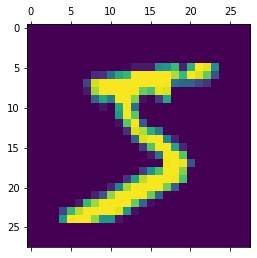

In [12]:
plt.matshow(X_train[0])

In [13]:
y_train[0]

5

In [14]:
X_train = X_train / 255
X_test = X_test / 255

In [15]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [16]:
X_train_flattened.shape

(60000, 784)

Using Flatten layer so that we don't have to call .reshape on input dataset

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2738 - accuracy: 0.9220
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1232 - accuracy: 0.9640
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0872 - accuracy: 0.9740
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0651 - accuracy: 0.9805
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0522 - accuracy: 0.9842


In [18]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0742 - accuracy: 0.9772


[0.0741770938038826, 0.9771999716758728]

In [19]:
model.save("./saved_model/")

INFO:tensorflow:Assets written to: ./saved_model/assets


# (1) Post training quantization

Witout quantization


In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

In [21]:
# size of litte model in kbs

len(tflite_model)

319776

Quantization


In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
# add this line
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [23]:
len(tflite_quant_model)

84720

above that quantizated model is 1/4th the size of a non quantized model

save models


In [24]:
with open("tflite_model.tflite", "wb") as f:
  f.write(tflite_model)


with open("tflite_quant_model.tflite", "wb") as f:
  f.write(tflite_quant_model)

# 2. Quantization aware training


In [26]:
!pip install tensorflow_model_optimization


     |████████████████████████████████| 213 kB 5.2 MB/s 


In [27]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)

q_aware_model.compile(optimizer= 'adam',
                      loss= 'sparse_categorical_crossentropy',
                      metrics= ['accuracy'])

q_aware_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [28]:
q_aware_model.fit(X_train, y_train, epochs= 5)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0436 - accuracy: 0.9866
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0344 - accuracy: 0.9890
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0280 - accuracy: 0.9912
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0230 - accuracy: 0.9927
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0194 - accuracy: 0.9939


In [29]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0839 - accuracy: 0.9769


[0.08391433954238892, 0.9768999814987183]

In [31]:
# loading an in memory model and applying quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpyaaeqosl/assets


INFO:tensorflow:Assets written to: /tmp/tmpyaaeqosl/assets


In [34]:
with open("tflite_qaware_model.tflite", "wb") as f:
  f.write(tflite_qaware_model)